In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
open_llm_perf_filtered_df = pd.read_csv('./data/open_llm_perf_filtered.csv', index_col=0).reset_index(drop=True)

# Dataset inspection

In [3]:
open_llm_perf_filtered_df.head()

,model,throughput,response_length,latency,energy,gpu,task,parameters_count,energy_per_token,dtype,...,ARC,HellaSwag,MMLU,TruthfulQA,Winogrande,GSM8K,Precision,#Params (B),Flagged,MoE
0,EleutherAI/gpt-neox-20b,27.4,256,9.34,3013.632,NVIDIA A100-SXM4-80GB,chat,20.0,0.00327,float16,...,45.73,73.45,25.00,31.61,68.90,5.46,float16,20.74,False,False
1,EleutherAI/gpt-neox-20b,25.6,256,10.00,2995.200,NVIDIA A100-SXM4-80GB,chat,20.0,0.00325,float16,...,45.73,73.45,25.00,31.61,68.90,5.46,float16,20.74,False,False
2,EleutherAI/gpt-neox-20b,27.5,256,9.32,2598.912,NVIDIA A100-SXM4-80GB,chat,20.0,0.00282,float16,...,45.73,73.45,25.00,31.61,68.90,5.46,float16,20.74,False,False
3,EleutherAI/gpt-neox-20b,23.5,256,10.90,3216.384,NVIDIA A100-SXM4-80GB,chat,20.0,0.00349,float16,...,45.73,73.45,25.00,31.61,68.90,5.46,float16,20.74,False,False
4,EleutherAI/pythia-12b,36.6,256,6.99,2101.248,NVIDIA A100-SXM4-80GB,chat,12.0,0.00228,float16,...,39.59,68.82,26.76,31.85,64.17,1.74,float16,12.00,False,False


In [4]:
open_llm_perf_filtered_df.describe()

,throughput,response_length,latency,energy,parameters_count,energy_per_token,optimization,Average,ARC,HellaSwag,MMLU,TruthfulQA,Winogrande,GSM8K,#Params (B)
count,261.000000,261.0,261.000000,261.000000,261.000000,261.000000,0.0,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,32.352490,256.0,8.872989,2587.238400,15.292874,0.002807,NaN,48.212069,48.986552,72.987203,42.433946,40.084483,70.756667,14.019923,14.869119
std,10.416712,0.0,3.429510,1264.591081,14.372474,0.001372,NaN,10.436420,10.614750,12.056841,15.327748,6.098649,8.187368,18.427849,14.675804
min,11.200000,256.0,3.230000,906.854400,7.000000,0.000984,NaN,30.150000,24.660000,25.620000,23.120000,31.610000,50.590000,0.000000,0.000000
25%,27.000000,256.0,6.590000,1797.120000,7.000000,0.001950,NaN,41.250000,41.130000,68.820000,27.680000,36.460000,67.170000,1.440000,7.000000
50%,32.600000,256.0,7.850000,2156.544000,10.000000,0.002340,NaN,46.640000,49.490000,75.820000,40.950000,38.760000,71.270000,4.930000,10.000000
75%,38.800000,256.0,9.490000,2829.312000,13.000000,0.003070,NaN,53.670000,58.530000,81.550000,55.670000,42.270000,76.640000,17.820000,13.020000
max,79.300000,256.0,22.800000,7833.600000,70.000000,0.008500,NaN,72.250000,67.920000,87.330000,76.350000,61.720000,84.140000,70.660000,68.980000


# Correlation study

In [5]:
num_feat = list(open_llm_perf_filtered_df.select_dtypes(include='number').columns)

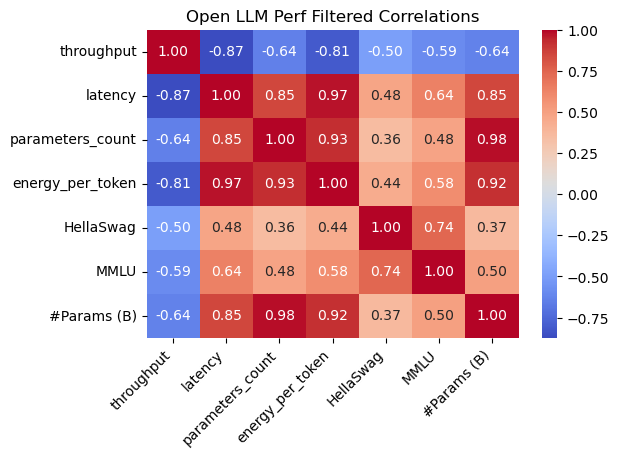

In [6]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    open_llm_perf_filtered_df[num_feat].drop([
        'energy', 'response_length', 'optimization', 'Average', 'ARC', 'TruthfulQA', 'Winogrande', 'GSM8K'
    ], axis=1).corr(numeric_only=True),
    annot=True, 
    cmap='coolwarm',
    fmt='.2f'
)

plt.title('Open LLM Perf Filtered Correlations')

plt.xticks(rotation=45, ha='right');

On note une corrélation positive entre les scores et les différentes caractéristiques des modèles, en particulier sur la latence et la consommation énergétique.

# Distribution analysis

In [7]:
sns.set_theme(style='darkgrid')

Text(0.5, 1.0, 'Nb of models per parameters_count')

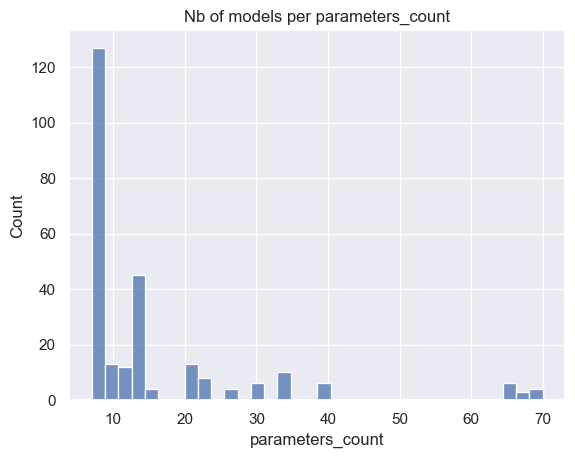

In [8]:
sns.histplot(data=open_llm_perf_filtered_df, x='parameters_count', color='b')
plt.title('Nb of models per parameters_count')

Text(0.5, 1.0, 'Nb of models per MMLU score')

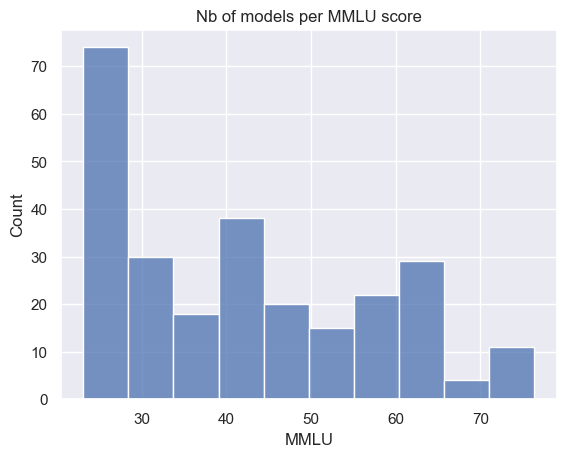

In [9]:
sns.histplot(data=open_llm_perf_filtered_df, x='MMLU', color='b')
plt.title('Nb of models per MMLU score')

Text(0.5, 1.0, 'Nb of models per MMLU score')

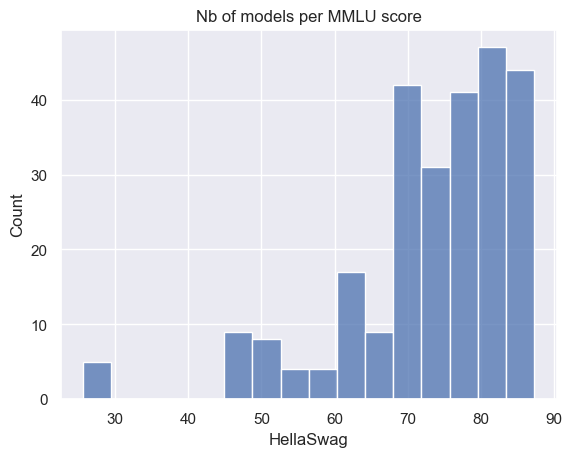

In [10]:
sns.histplot(data=open_llm_perf_filtered_df, x='HellaSwag', color='b')
plt.title('Nb of models per MMLU score')

# Parameters count binning

In [11]:
# binning values based on Open_LLM_Leaderboard binning values choice
open_llm_perf_filtered_df['parameters_count_bins'] = pd.cut(open_llm_perf_filtered_df['parameters_count'], [7, 13, 35, 60, 70])

Text(0.5, 1.0, 'Nb of models per parameters_count bins')

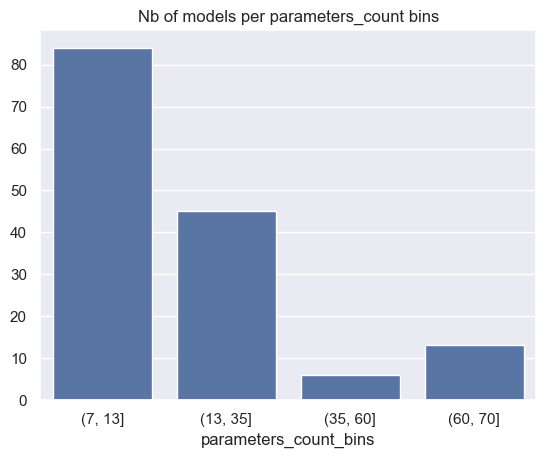

In [12]:
bins_counts = open_llm_perf_filtered_df['parameters_count_bins'].value_counts()
sns.barplot(x=bins_counts.index, y=bins_counts.values, color='b')
plt.title('Nb of models per parameters_count bins')

# Average scores

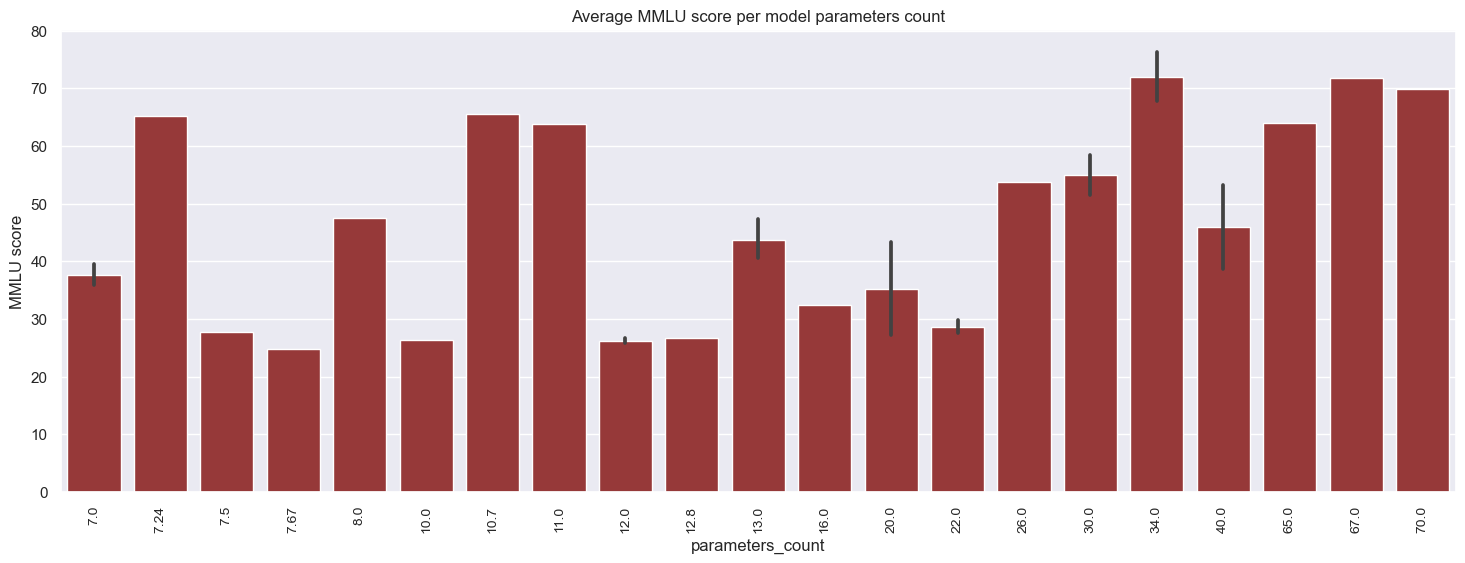

In [13]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='parameters_count', y='MMLU', color='brown')
plt.title('Average MMLU score per model parameters count')
plt.xlabel('parameters_count')
plt.ylabel('MMLU score')
plt.xticks(rotation=90, fontsize=10)
plt.show()

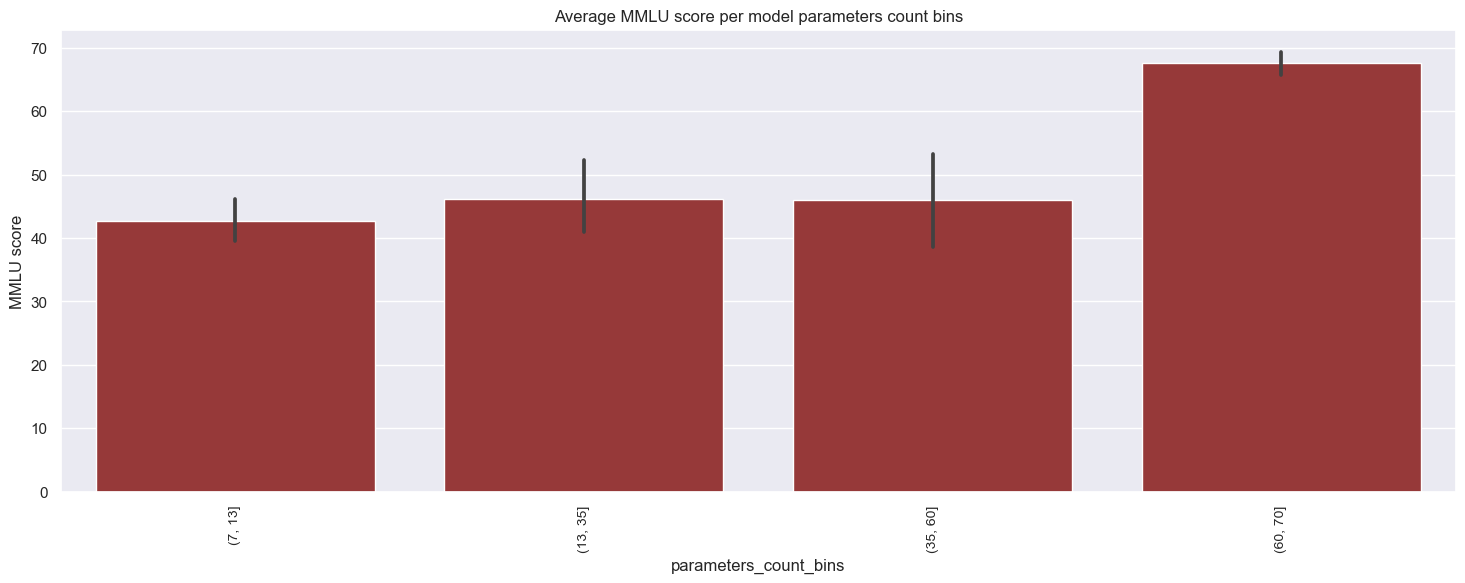

In [14]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='parameters_count_bins', y='MMLU', color='brown')
plt.title('Average MMLU score per model parameters count bins')
plt.xlabel('parameters_count_bins')
plt.ylabel('MMLU score')
plt.xticks(rotation=90, fontsize=10)
plt.show()

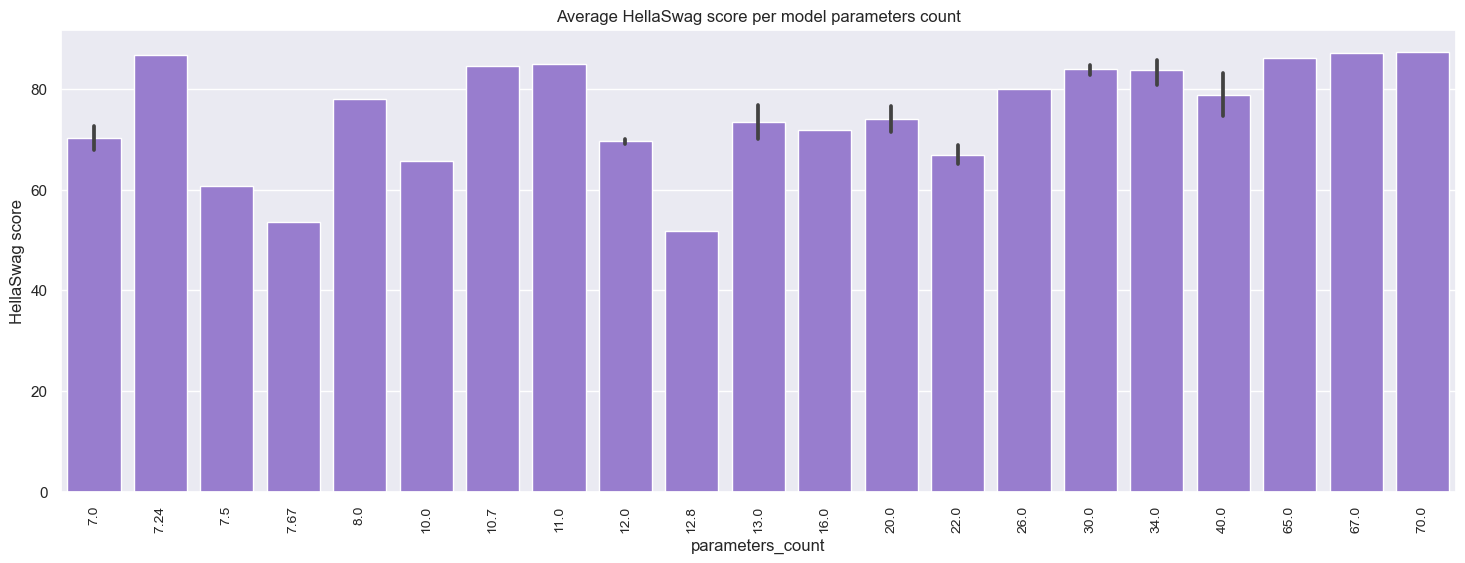

In [15]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='parameters_count', y='HellaSwag', color='mediumpurple')
plt.title('Average HellaSwag score per model parameters count')
plt.xlabel('parameters_count')
plt.ylabel('HellaSwag score')
plt.xticks(rotation=90, fontsize=10)
plt.show()

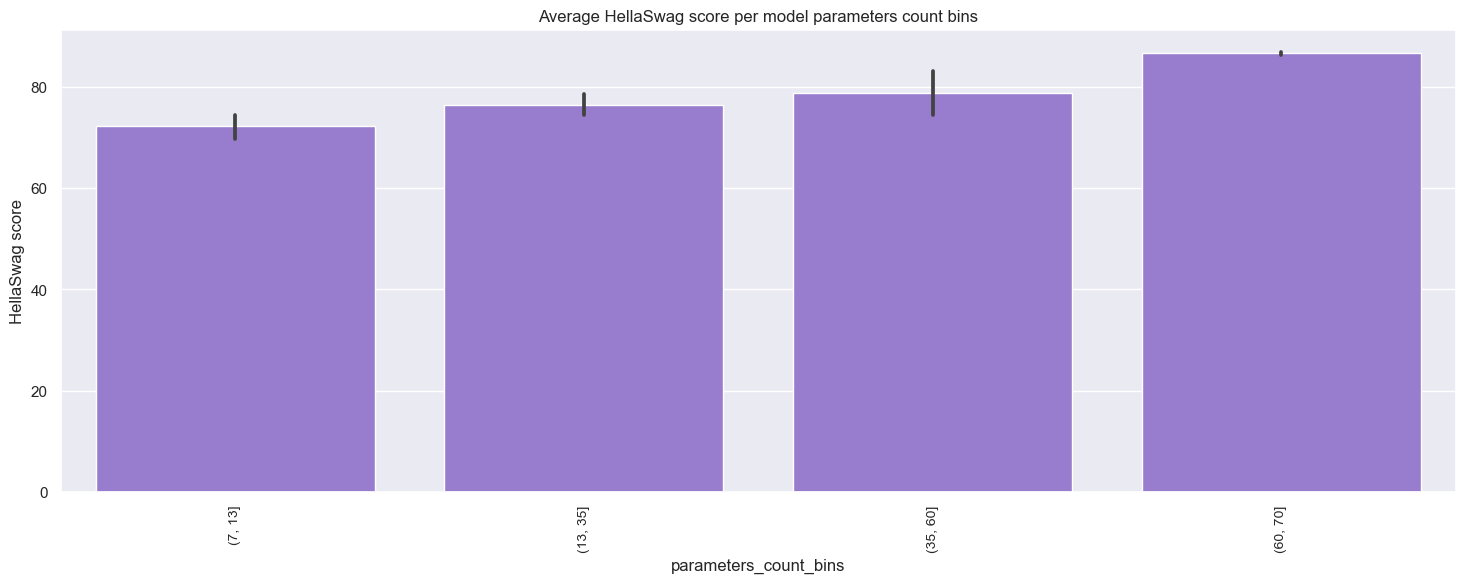

In [16]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='parameters_count_bins', y='HellaSwag', color='mediumpurple')
plt.title('Average HellaSwag score per model parameters count bins')
plt.xlabel('parameters_count_bins')
plt.ylabel('HellaSwag score')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Average energy/token

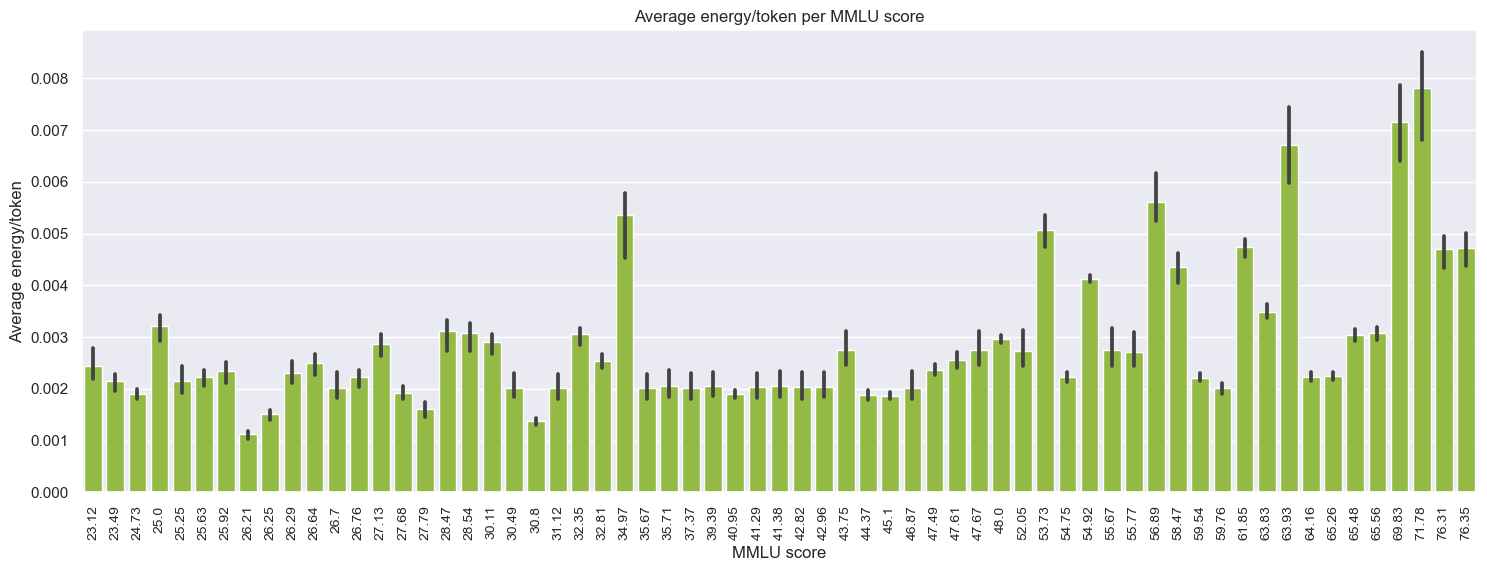

In [17]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='MMLU', y='energy_per_token', color='yellowgreen')
plt.title('Average energy/token per MMLU score')
plt.xlabel('MMLU score')
plt.ylabel('Average energy/token')
plt.xticks(rotation=90, fontsize=10)
plt.show()

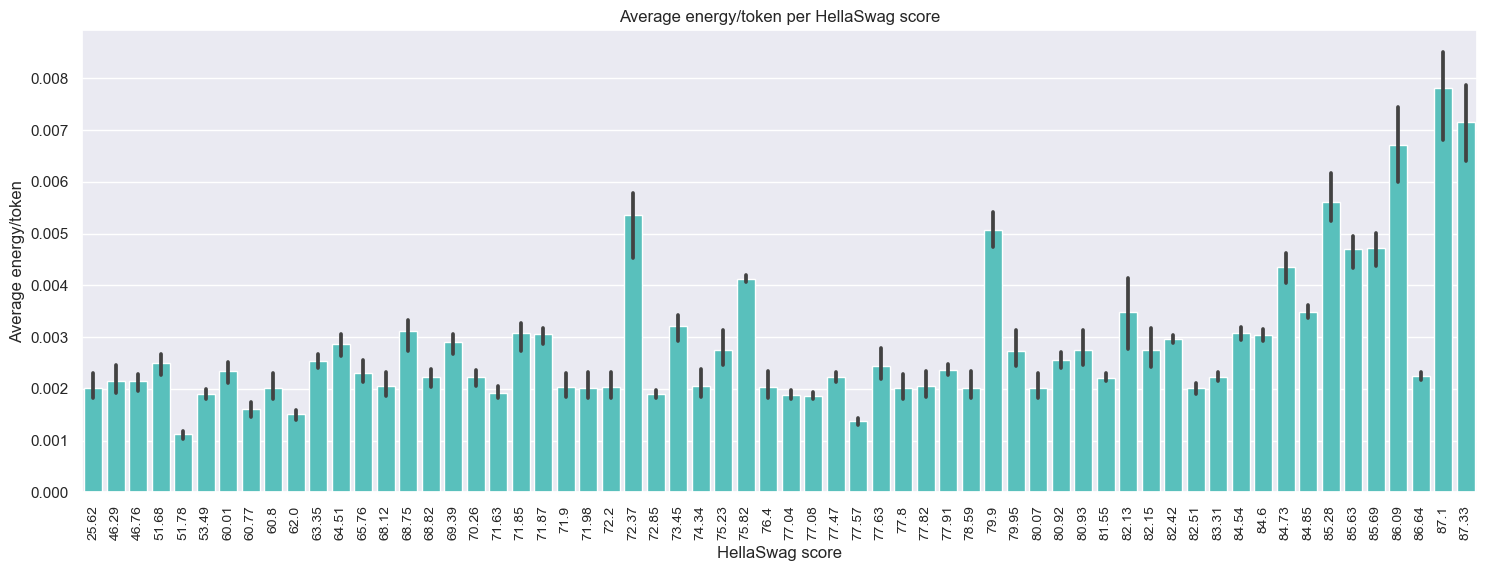

In [18]:
plt.figure(figsize=(18, 6))
sns.barplot(data=open_llm_perf_filtered_df, x='HellaSwag', y='energy_per_token', color='mediumturquoise')
plt.title('Average energy/token per HellaSwag score')
plt.xlabel('HellaSwag score')
plt.ylabel('Average energy/token')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# Linear regressions

### MMLU

In [19]:
x_range = np.array([
    open_llm_perf_filtered_df['MMLU'].min(),
    open_llm_perf_filtered_df['MMLU'].max()
]).reshape(-1, 1)

x = open_llm_perf_filtered_df['MMLU']
y = open_llm_perf_filtered_df['energy_per_token']

poly = PolynomialFeatures(degree=1)
X = np.array(x).reshape(-1, 1)
poly.fit(X)
X_poly = poly.transform(X)
x_range_poly = poly.transform(x_range)
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, y)
y_range_poly = model.predict(x_range_poly)

print(f'Coef and intercept for A100: {model.coef_[1]}, {model.intercept_}')

Coef and intercept for A100: 5.236102217789186e-05, 0.0005854485268738667


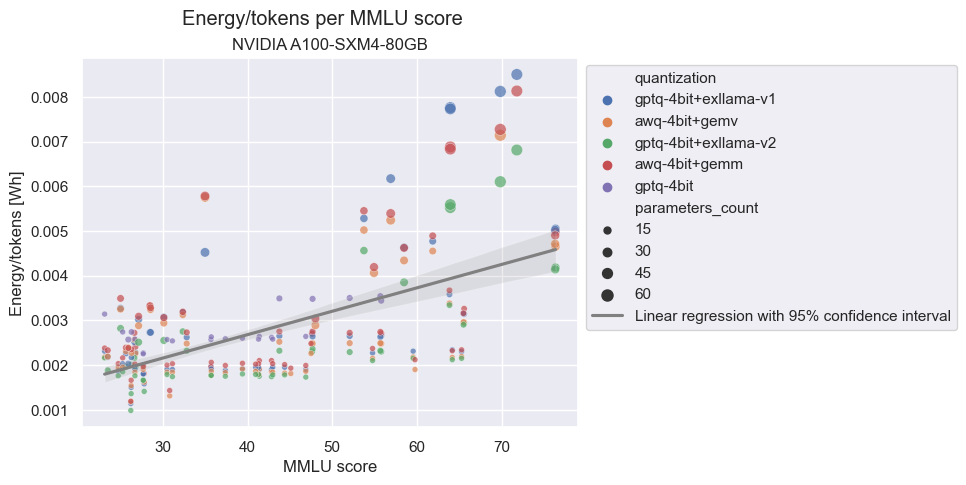

In [20]:
sns.scatterplot(
    data=open_llm_perf_filtered_df, 
    x='MMLU', 
    y='energy_per_token', 
    hue='quantization',
    size='parameters_count',
    alpha=0.7
)

sns.regplot(
    data=open_llm_perf_filtered_df, 
    x='MMLU', 
    y='energy_per_token',
    scatter=False,
    color='grey',
    label='Linear regression with 95% confidence interval'
)

plt.suptitle('Energy/tokens per MMLU score')
plt.title('NVIDIA A100-SXM4-80GB')
plt.xlabel('MMLU score')
plt.ylabel('Energy/tokens [Wh]')

plt.legend(bbox_to_anchor=(1, 1));

### HellaSwag

#### All scores

In [21]:
x_range = np.array([
    open_llm_perf_filtered_df['HellaSwag'].min(),
    open_llm_perf_filtered_df['HellaSwag'].max()
]).reshape(-1, 1)

x = open_llm_perf_filtered_df['HellaSwag']
y = open_llm_perf_filtered_df['energy_per_token']

poly = PolynomialFeatures(degree=1)
X = np.array(x).reshape(-1, 1)
poly.fit(X)
X_poly = poly.transform(X)
x_range_poly = poly.transform(x_range)
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, y)
y_range_poly = model.predict(x_range_poly)

print(f'Coef and intercept for A100: {model.coef_[1]}, {model.intercept_}')

Coef and intercept for A100: 5.0096517775349224e-05, -0.000849071382392185


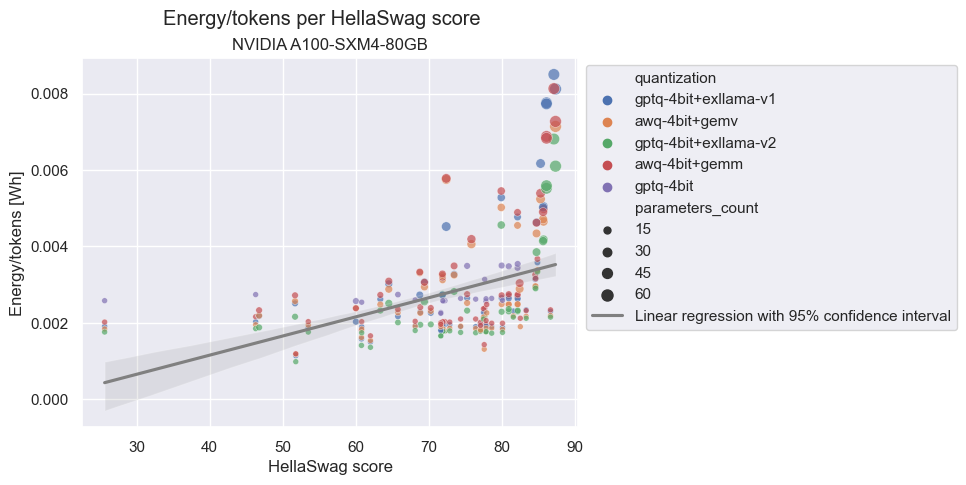

In [22]:
sns.scatterplot(
    data=open_llm_perf_filtered_df, 
    x='HellaSwag', 
    y='energy_per_token', 
    hue='quantization',
    size='parameters_count',
    alpha=0.7
)

sns.regplot(
    data=open_llm_perf_filtered_df, 
    x='HellaSwag', 
    y='energy_per_token',
    scatter=False,
    color='grey',
    label='Linear regression with 95% confidence interval'
)

plt.suptitle('Energy/tokens per HellaSwag score')
plt.title('NVIDIA A100-SXM4-80GB')
plt.xlabel('HellaSwag score')
plt.ylabel('Energy/tokens [Wh]')

plt.legend(bbox_to_anchor=(1, 1));

On note quelques outliers en-dessous de 30. Un filtrage au-dessus de cette valeur peut permettre une régression moins biaisée.

#### Scores > 40

In [23]:
medium_large_HS_scores_df = open_llm_perf_filtered_df[open_llm_perf_filtered_df['HellaSwag'] > 40]

In [24]:
x_range = np.array([
    medium_large_HS_scores_df['HellaSwag'].min(),
    medium_large_HS_scores_df['HellaSwag'].max()
]).reshape(-1, 1)

x = medium_large_HS_scores_df['HellaSwag']
y = medium_large_HS_scores_df['energy_per_token']

poly = PolynomialFeatures(degree=1)
X = np.array(x).reshape(-1, 1)
poly.fit(X)
X_poly = poly.transform(X)
x_range_poly = poly.transform(x_range)
model = LinearRegression(fit_intercept=True)
model.fit(X_poly, y)
y_range_poly = model.predict(x_range_poly)

print(f'Coef and intercept for A100: {model.coef_[1]}, {model.intercept_}')

Coef and intercept for A100: 6.464018241145884e-05, -0.0019550355074584537


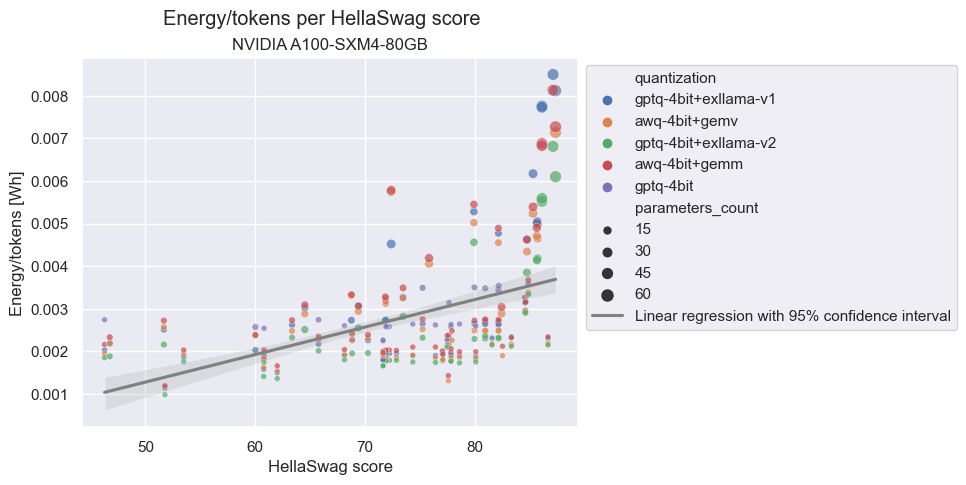

In [25]:
sns.scatterplot(
    data=medium_large_HS_scores_df, 
    x='HellaSwag', 
    y='energy_per_token', 
    hue='quantization',
    size='parameters_count',
    alpha=0.7
)

sns.regplot(
    data=medium_large_HS_scores_df, 
    x='HellaSwag', 
    y='energy_per_token',
    scatter=False,
    color='grey',
    label='Linear regression with 95% confidence interval'
)

plt.suptitle('Energy/tokens per HellaSwag score')
plt.title('NVIDIA A100-SXM4-80GB')
plt.xlabel('HellaSwag score')
plt.ylabel('Energy/tokens [Wh]')

plt.legend(bbox_to_anchor=(1, 1));